# Double Jet

With various grid sizes

In [1]:
from gpuocean.utils import Common, IPythonMagic

from importlib import reload

import numpy as np
import copy
import pycuda.driver as cuda
from matplotlib import pyplot as plt

plt.style.use('dark_background')

plt.rcParams["image.origin"] = "lower"


In [2]:
%cuda_context_handler gpu_ctx

In [3]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.DoubleJetPlot import *

Get initial arguments from class

In [4]:
from gpuocean.utils import DoubleJetCase

In [5]:
doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=256, nx=512)
doubleJetCase_args, doubleJetCase_init, _ = doubleJetCase.getInitConditions()

## Truth

In [6]:
truth_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetTruth/2023-10-30T13_00_13"

true_state = np.load(os.path.join(truth_path, "truth_864000.npy"))

(<Figure size 1500x1000 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

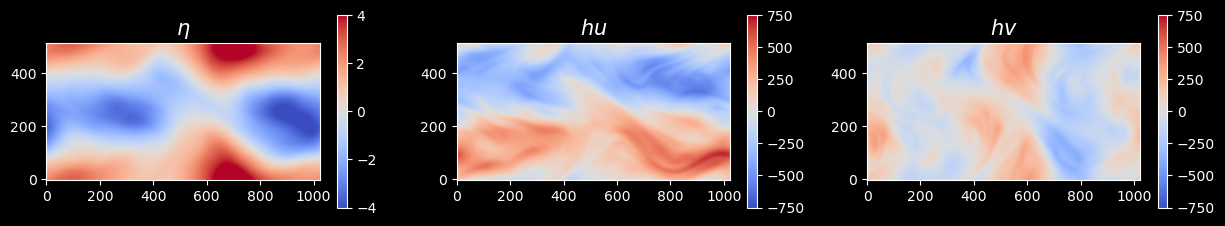

In [7]:
imshow3(true_state, eta_vlim=4)

## Ensembles

In [8]:
from utils.DoubleJetSL import *

In [9]:
slda_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetSLDA/2023-11-05T19_13_08"

sl_state = np.load(os.path.join(slda_path, "SLstates/SLensemble_864000.npy"))

In [10]:
def MLestimator(ML_state, func, **kwargs):
    numLevels = len(ML_state)
    MLest = np.zeros(ML_state[-1][0].shape[:-1])
    MLest += func(ML_state[0], axis=-1, **kwargs).repeat(2**(numLevels-1),1).repeat(2**(numLevels-1),2)
    for l_idx in range(1, numLevels):
        MLest += (func(ML_state[l_idx][0], axis=-1, **kwargs) - func(ML_state[l_idx][1], axis=-1, **kwargs).repeat(2,1).repeat(2,2)).repeat(2**(numLevels-l_idx-1),1).repeat(2**(numLevels-l_idx-1),2)
    return MLest

In [11]:
def plot_MLstates(ml_state):
    from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
    from mpl_toolkits.axes_grid1.colorbar import colorbar

    from gpuocean.ensembles import MultiLevelOceanEnsemble
    fig, axs = plt.subplots(3,3, figsize=(20,15))

    def _add_cb(ax, im, label=None):
        ax_divider = make_axes_locatable(ax)
        ax_cb = ax_divider.append_axes("top", size="10%", pad="5%")
        cbar = colorbar(im, cax=ax_cb, orientation="horizontal")
        ax_cb.xaxis.set_ticks_position("top")
        ax_cb.set_title(label)


    ML_mean = MLestimator(ml_state, np.mean)
    vlims = [4, 750, 750]
    for i in range(3):
        im = axs[0,i].imshow(ML_mean[i], cmap=plt.cm.coolwarm, vmin=-vlims[i], vmax=vlims[i])
        _add_cb(axs[0,i], im)

    ML_std = MLestimator(ml_state, np.std, ddof=1)
    vlims = [0.5, 100, 100]
    for i in range(3):
        im = axs[1,i].imshow(ML_std[i], cmap=plt.cm.Oranges, vmin=0, vmax=vlims[i])
        _add_cb(axs[1,i], im)

    ML_err = np.abs(ML_mean - true_state) 
    vlims = [0.5, 100, 100]
    for i in range(3):
        im = axs[2,i].imshow(ML_err[i], cmap=plt.cm.Reds, vmin=0, vmax=vlims[i])
        _add_cb(axs[2,i], im)

In [12]:
mlda2_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetMLDA/2023-11-02T17_53_49"

ML2_state = []

ML2_state.append(np.load(mlda2_path+"/MLstates/MLensemble_0.npy"))

numLevels = len(set([f.split("_")[1][0] for f in os.listdir(mlda2_path+"/MLstates")]))
for l_idx in range(1, numLevels):
    ML2_state.append( [np.load(mlda2_path+"/MLstates/MLensemble_"+str(l_idx)+"_0.npy"), np.load(mlda2_path+"/MLstates/MLensemble_"+str(l_idx)+"_1.npy")] )


In [13]:
mlda3_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetMLDA/2023-11-02T17_54_00"

ML3_state = []

ML3_state.append(np.load(mlda3_path+"/MLstates/MLensemble_0.npy"))

numLevels = len(set([f.split("_")[1][0] for f in os.listdir(mlda3_path+"/MLstates")]))
for l_idx in range(1, numLevels):
    ML3_state.append( [np.load(mlda3_path+"/MLstates/MLensemble_"+str(l_idx)+"_0.npy"), np.load(mlda3_path+"/MLstates/MLensemble_"+str(l_idx)+"_1.npy")] )

In [14]:
def MLMSE(ML_state, true_state):
    numLevels = len(ML_state)
    MLest = np.zeros(ML_state[-1][0].shape[:-1])
    MLest += np.mean((ML_state[0].repeat(2**(numLevels-1),1).repeat(2**(numLevels-1),2) - true_state[:,:,:,np.newaxis])**2, axis=-1) 
    for l_idx in range(1, numLevels):
        MLest += np.mean((ML_state[l_idx][0].repeat(2**(numLevels-l_idx-1),1).repeat(2**(numLevels-l_idx-1),2) - true_state[:,:,:,np.newaxis])**2
                          - (ML_state[l_idx][1].repeat(2**(numLevels-l_idx),1).repeat(2**(numLevels-l_idx),2) - true_state[:,:,:,np.newaxis])**2,
                          axis=-1)
    return np.sqrt(np.maximum(0,MLest))

(<Figure size 1500x1000 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

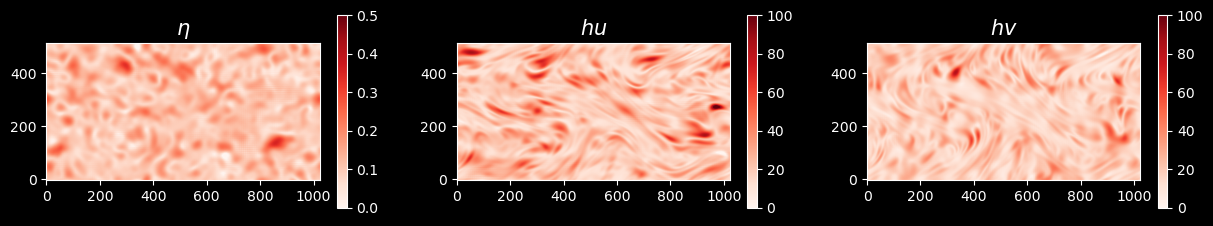

In [15]:
imshow3var(MLMSE(ML2_state, true_state), eta_vlim=0.5, huv_vlim=100)

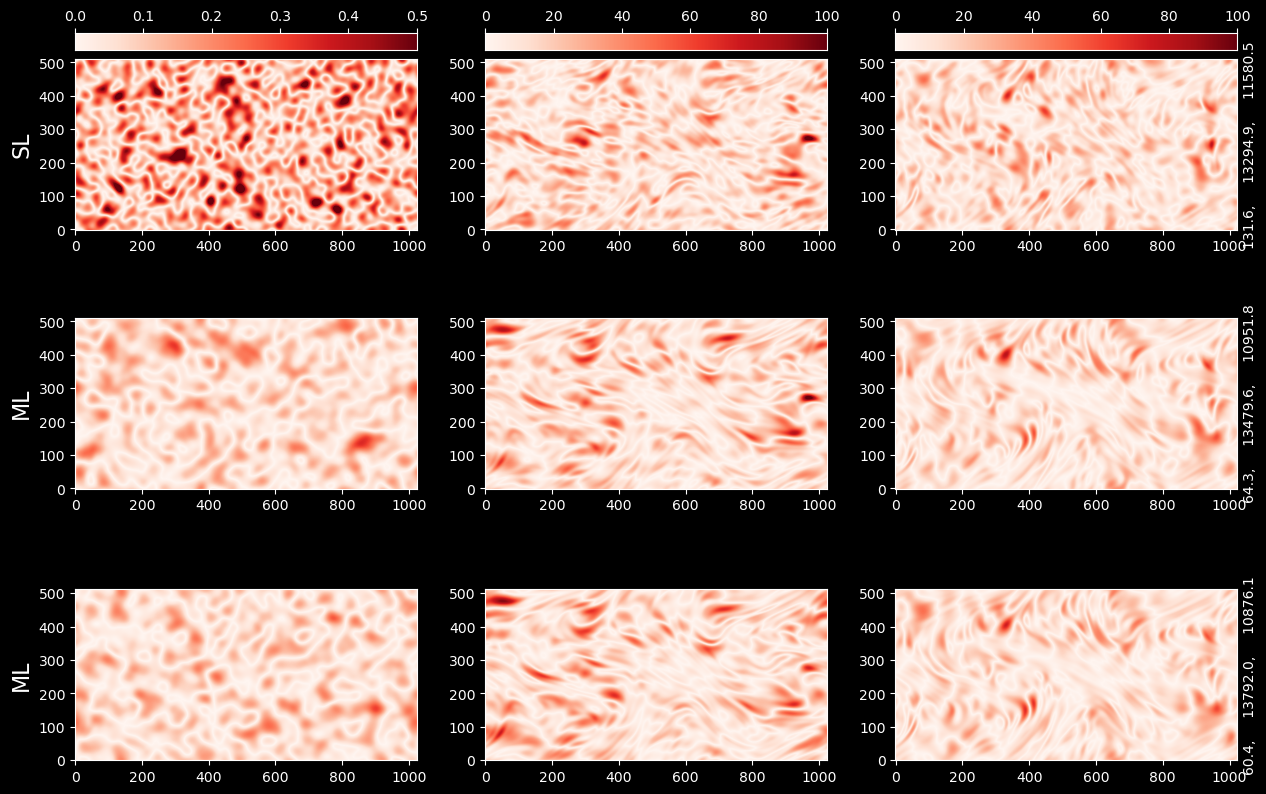

In [20]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

fig, axs = plt.subplots(3,3, figsize=(15,10))

def _add_cb(ax, im, label=None):
    ax_divider = make_axes_locatable(ax)
    ax_cb = ax_divider.append_axes("top", size="10%", pad="5%")
    cbar = colorbar(im, cax=ax_cb, orientation="horizontal")
    ax_cb.xaxis.set_ticks_position("top")
    ax_cb.set_title(label)

vlims=[0.5, 100, 100]
def _plot3(axs, state, cbar=False):
    for i in range(3):
        im = axs[i].imshow(state[i], cmap=plt.cm.Reds, vmin=0, vmax=vlims[i])
        if cbar:
            _add_cb(axs[i], im)
    axs[2].yaxis.set_label_position("right")
    axs[2].set_ylabel(",     ".join(["{:.1f}".format(v) for v in np.linalg.norm(state, axis=(1,2))]), fontsize=10)


axs[0,0].set_ylabel("SL", fontsize=16)
SL_err = np.abs(np.mean(sl_state, axis=-1).repeat(1,1).repeat(1,2) - true_state)
_plot3(axs[0], SL_err, cbar=True) 

axs[1,0].set_ylabel("ML", fontsize=16)
ML2_err = np.abs(MLestimator(ML2_state, np.mean) - true_state)
_plot3(axs[1], ML2_err) 

axs[2,0].set_ylabel("ML", fontsize=16)
ML3_err = np.abs(MLestimator(ML3_state, np.mean) - true_state)
_plot3(axs[2], ML3_err) 


In [23]:
Ts = np.arange(0, 13*24*3600, 900)/(24*3600)

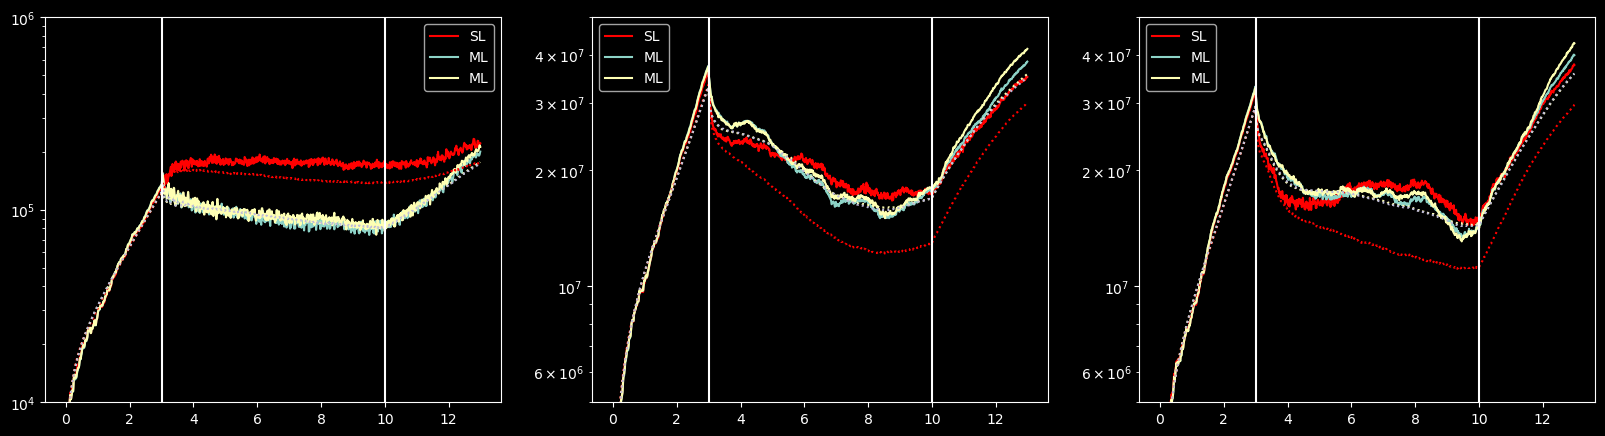

In [39]:
fig, axs = plt.subplots(1,3, figsize=(20,5))

sl_rmse  = np.load(slda_path  + "/rmse.npy")
ml2_rmse = np.load(mlda2_path + "/MLrmses_posterior.npy")
ml3_rmse = np.load(mlda3_path + "/MLrmses_posterior.npy")

sl_std  = np.load(slda_path  + "/stddev.npy")
ml2_std = np.load(mlda2_path + "/MLstddevs_posterior.npy")
ml3_std = np.load(mlda3_path + "/MLstddevs_posterior.npy")

for i in range(3):
    axs[i].set_yscale("log")
    axs[i].plot(Ts, sl_rmse[:,i],  c="red", label = "SL")
    axs[i].plot(Ts, ml2_rmse[:,i], c="C0",  label="ML")
    axs[i].plot(Ts, ml3_rmse[:,i], c="C1",  label="ML")

    axs[i].plot(Ts, sl_std[:,i], c="red", ls="dotted")
    axs[i].plot(Ts, ml2_std[:,i], c="C1", ls="dotted")
    axs[i].plot(Ts, ml3_std[:,i], c="C2", ls="dotted")

    axs[i].axvline(3, c="white")
    axs[i].axvline(10, c="white")
    axs[i].legend()
    
    if i == 0:
        axs[i].set_ylim((1e4, 1e6))
    else:
        axs[i].set_ylim((5e6, 5e7))


# for i in range(1,3):
#     axs[i].axhline(np.sqrt(np.sum(500*np.ones((doubleJetCase_args["nx"],doubleJetCase_args["ny"]))*doubleJetCase_args["dx"]*doubleJetCase_args["dy"])), c="black")


In [40]:
np.amax(sl_rmse[:,2]/ml2_rmse[:,2])

1.1351179416080244

In [42]:
np.mean(sl_rmse[600:,2]/ml2_rmse[600:,2])

1.0367012005674616